# Amazon Fine Food Reviews Sentiment Analysis - Naive Bayes

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews 

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10<br>

Attribute Information:

Id<br>
ProductId - unique identifier for the product<br>
UserId - unqiue identifier for the user<br>
ProfileName<br>
HelpfulnessNumerator - number of users who found the review helpful<br>
HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not<br>
Score - rating between 1 and 5<br>
Time - timestamp for the review<br>
Summary - brief summary of the review<br>
Text - text of the review<br>

Text - text of the review<br>
Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?


[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Reading Data

In [2]:
# Establishing connection with sqlite3
con = sqlite3.connect(r"C:\Users\suraj\ML_Projects\My\Practice\3_NLP- AmazonFoodreviews\database.sqlite")

# Retrieving data from database
data =  pd.read_sql_query("select * from Reviews where score != 3", con)

data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
data.shape

(525814, 10)

### Replacing score as 1 and 0

In [4]:
#replacing values (4,5) with 1 and (1,2) as 0
score_list=[]
for s in data["Score"]:
    if s > 3:
        score_list.append(1)
    else:
        score_list.append(0)

In [5]:
data["Score"] = score_list

data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
data.shape

(525814, 10)

## EDA

### Deduplication

In [7]:
pd.read_sql_query("select * from reviews where UserId='#oc-R11D9D7SHXIJB9'",con)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
1,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
2,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."


In Above table we can observe that the same user at same time has given the same the review for different products, which seems wrong. Hence the data is duplicate which should be removed

In [8]:
# droping duplicate values

sorted_data = data.sort_values("ProductId", inplace = False, kind="quicksort", ascending=True, axis=0, na_position="last")

final = sorted_data.drop_duplicates(subset={"UserId", "ProfileName", "Time","Text"}, keep="first", inplace=False)

In [9]:
final.shape

(364173, 10)

In [10]:
sorted_data.shape

(525814, 10)

We can also observe that at some places the HelpfulnessNumerator is more than HelpfulnessDenominator, which shouldn't.
Hence shuch data should be removed.

In [11]:
# Removing datapoints whose Helpfulnumerator value is greater than helpfulnessdenominator
final =final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [12]:
final.shape

(364171, 10)

In [13]:
final["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

# PreProcessing

## Preprocessing ReviewText
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from tqdm import tqdm

In [15]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

# function for decontacting the words
def contractions(text):
    #specifics
    phrase = re.sub(r"don't","do not",text)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [16]:
# https://gist.github.com/sebleier/554280
# removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [17]:
final["Text"].values[12670]

"I have been a big believer in Bragg's Apple Cider Vinegar with Mother for acid reflux.  While ordering more vinegar I decided to try a bottle of their Olive Oil and it is very good and at a very good price for organic Olive Oil.  The packing was amazing, I think you could have dropped the box off the top of a building and the bottle would be protected.  It took me quite awhile to get the tons of bubble wrap off the bottle.  But then again, it's a good thing, you don't want a broken bottle of Olive Oil."

In [18]:
# removing urls, html tags, alpha numeric characters, special charatcers and stopwords
# Combining all of the above concepts
from tqdm import tqdm_notebook
preprocessed_reviews = []
# tqdm is for printing the status bar
for review in tqdm_notebook(final["Text"].values):
    sentence = re.sub(r"http\S+","",review)
    sentence = BeautifulSoup(sentence, "lxml").get_text()
    sentence = contractions(sentence)
    sentence = re.sub(r"\S*\d\S*","", sentence).strip()
    sentence = re.sub(r"[^A-Za-z0-9]+"," ",sentence)
    sentence = ' '.join(sen.lower() for sen in sentence.split() if sen.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

In [25]:
# Adding cleaned reviews into Text column
final["Text"] = preprocessed_reviews

In [26]:
final["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [27]:
final.shape

(364171, 10)

## Dealing with Imbalaced Data

From value counts we can observe that the data is imbalanced , hence the naive bayes gets affected by imbalaced data noticeably, or the naive bayes is influced by the majority class. The techniques to deal with imbalanced data are:

    1) Undersampling
    2) Oversampling
    3) Creating Artificial DataPoints.
    4) Class weight

In this case I will we performing Oversampling. ie I will create more negative points.

In [28]:
# Separating positive and negative reviews
cleaned_positive = pd.DataFrame(final[final["Score"] == 1])
cleaned_negative = pd.DataFrame(final[final["Score"] == 0])
print(cleaned_positive.shape, cleaned_negative.shape)

(307061, 10) (57110, 10)


In [29]:
positive_review_counts, negative_review_counts = final["Score"].value_counts()

# Sampling the negative points and making it equal to positive points.
cleaned_negative = cleaned_negative.sample(positive_review_counts, replace=True)
print("Oversampled Negative datapoints shape:",cleaned_negative.shape)

# Concatenating positive and negative reviews
balanced_reviews = pd.concat([cleaned_positive, cleaned_negative])
print("SHape after concatenated: ",balanced_reviews.shape)

# Shuffling positive and Negative reviews adn dropping index which will be created by pandas while shuffling
balanced_reviews = balanced_reviews.sample(frac=1).reset_index(drop=True)

Oversampled Negative datapoints shape: (307061, 10)
SHape after concatenated:  (614122, 10)


# BOW

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve

In [31]:
# # function for finding optimal alpha

# alphas = list(np.round(np.arange(1,30,0.5),2))
# cv_scores = []  # for storing cross validation scores
# def alpha(x_train,y_train):
        
#         #Performing 10-fold CV
#         for i in tqdm(alphas):
#             mnb = MultinomialNB(alpha=i)
#             cv_accuracy = cross_val_score(mnb,x_train, y_train,cv=10, scoring="accuracy")
#             cv_scores.append(cv_accuracy.mean())
        
#         #String MissClassification error i.e 1 - accuracy
#         MSE = [(1-x) for x in cv_scores]
#         print("\nMSE SCores", MSE)
#         print("CV_Acores", cv_scores)
        
#         #Finding optimal value of alpha
#         optimal_alpha = alphas[MSE.index(min(MSE))]
        
#         #Plotting Train_Test_CV_Error
#         plt.figure(figsize=(10,10))
#         plt.plot(alphas, MSE)
#         for xy in zip(alphas, np.round(MSE,2)):
#             plt.annotate(f'{xy}',xy, textcoords="data")
#             plt.xlabel("alpha")
#             plt.ylabel("MSE")
#             plt.title("MSE GRAPH")
#             plt.show()
#         return optimal_alpha
         
    

In [43]:
def alpha(x,y):
    alphas = list(np.round(np.arange(1,30,0.5),2))
    cv_scores = []
    roc_auc_score = []
    #performing 10-fold CV
    for i in tqdm_notebook(alphas):
        
        mnb = MultinomialNB(alpha=i)
            
        #code is for accuracy score
        cv_accuracy = cross_val_score(mnb,x, y,cv=10, scoring="accuracy")
        cv_scores.append(cv_accuracy.mean())
        
        #code for  roc_auc score
        cross_roc_auc_score = cross_val_score(mnb, x,y, cv=10, scoring="roc_auc")
        roc_auc_score.append(cross_roc_auc_score.mean())
        
    # MissClassificationScore i.e 1-accuracy
    MSE = [(1-x) for x in cv_scores]   
    
    #optimalk using accuracy
    optimal_alpha = alphas[MSE.index(min(MSE))]
    
    #optimal-alpha using auc
    optimal_alpha_roc = alphas[roc_auc_score.index(max(roc_auc_score))]
    
    print(f"Alpha using accuracy {optimal_alpha} \nAlpha using roc_auc {optimal_alpha_roc}")
    
    #Plotting Train_Test_CV_Error Graph
    #plt.figure(figsize=(10,10))
    plt.plot(alphas, MSE)
    #adding text to xy points
    for xy in zip(alphas, np.round(MSE,2)):
        plt.annotate(f'{xy}', xy, textcoords='data')
    plt.xlabel("alpha")
    plt.ylabel("MSE")
    plt.title("Train_Test_CV_Error")
    plt.show()
    
    # Plotting grpad for k vs roc_auc_score
    plt.plot(alphas, roc_auc_score)
    plt.plot(alphas, roc_auc_score, "ro")
    plt.xlabel("alpha")
    plt.ylabel("Auc")
    plt.show()
    
    return optimal_alpha

In [33]:
# Splitting data into train and test dataset

X = balanced_reviews["Text"].values
Y = balanced_reviews['Score'].values

X_train, X_test, y_train, y_test = train_test_split(X,Y ,test_size=0.3, random_state=0)

print('Shape before vectorization')
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Featurization -> Text to BOW

vectorizer = CountVectorizer()

X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

print('Shape after vectorization')
print(X_train_bow.shape, X_test_bow.shape)

Shape before vectorization
(429885,) (429885,)
(184237,) (184237,)
Shape after vectorization
(429885, 100329) (184237, 100329)



K using accuracy 1.0 
 K using roc_auc 1.0


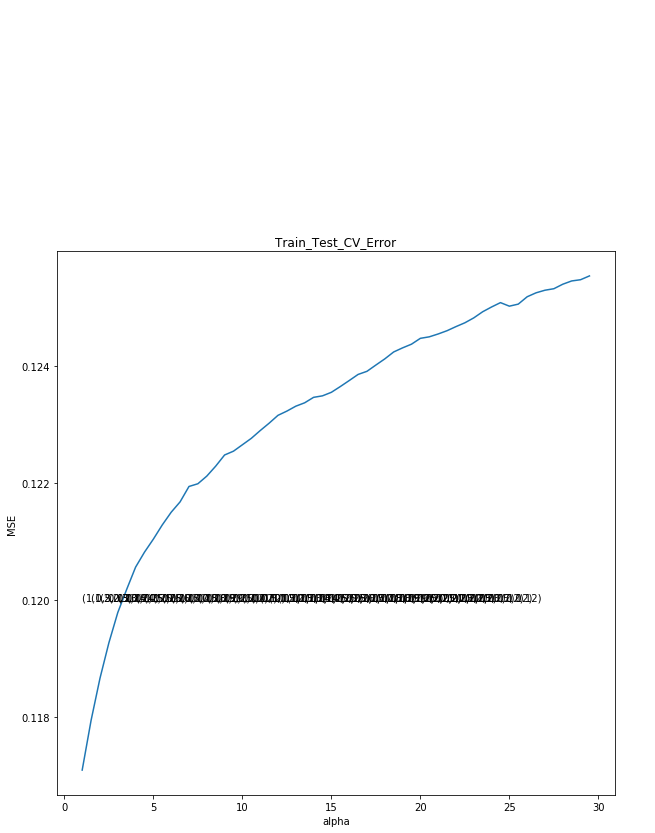

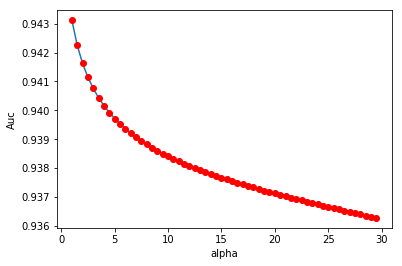

1.0

In [44]:
# Geting optimal value of alpha from aplha()

opt_alpha = alpha(X_train_bow, y_train)
opt_alpha

### Performance metrics

Optimal aplha using accuracy = 1
Optimal alpha using roc_auc = 1

Hence choosing alpha = 1

## Applying Naive Bayes 

In [51]:
# Naive Bayes using optimal values returned by alpha()
# Initiating Naive bayes 
nb_optimal = MultinomialNB(alpha=opt_alpha, class_prior=None, fit_prior=True) 
""" class_prior = class_prior probablity. it cab be kept None or value can be passed btw 0-1 whihc will used for calculating
                    the probablity.
    fir_prior = Whether to learn prior probalities or not. If false then it assumes uniform prior probalities
"""

# Letiing Naive Bayes model learn
nb_optimal.fit(X_train_bow,y_train)

#Predicting Positive or negative using X_test
pred = nb_optimal.predict(X_test_bow)

accuracy_test = accuracy_score(y_test, pred, normalize=True)*float(100)
print("Test Accuracy: ", accuracy_test)


#Predicting Positive or negative using X_train
pred_train = nb_optimal.predict(X_train_bow)

""" ACCURACY """

accuracy_train = accuracy_score(y_train, pred_train, normalize=True)*float(100)
print("Train Accuracy: ", accuracy_train)

# # or another for accuracy measuring for train and test

# pred_train_2 = nb_optimal.score(X_train_bow, y_train)
# print("Train Accuracy using nb method", pred_train_2*100)

# pred_train_3 = nb_optimal.score(X_test_bow, y_test)
# print("Test Accuracy using nb method", pred_train_3*100)

""" ROC_AUC"""
proba_test = roc_auc_score(y_test, nb_optimal.predict_proba(X_test_bow)[:,1])

proba_train = roc_auc_score(y_train, nb_optimal.predict_proba(X_train_bow)[:,1])

print("*"*10)
print("Test auc: ", proba_test)
print("Train auc: ", proba_train)


Test Accuracy:  88.41763597974348
Train Accuracy:  89.08987287297766
**********
Test auc:  0.9443481960076567
Train auc:  0.9500588824469713


Observation:

The accuracy on train data and accuracy of test data is almost same, as well as the auc of both is similar


Hence we can conclude that the bias and variance tradeoff is well balanced

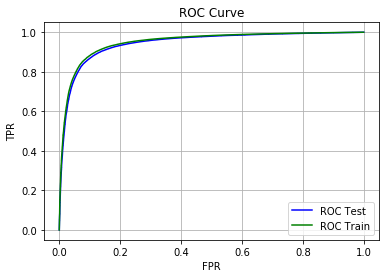

In [72]:
# Generating roc graph

fpr, tpr, thresholds = roc_curve(y_test,nb_optimal.predict_proba(X_test_bow)[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,nb_optimal.predict_proba(X_train_bow)[:,1])

plt.plot(fpr,tpr, "b", label="ROC Test")
plt.plot(fpr_train, tpr_train, "g", label="ROC Train")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

From roc graph we can observe that the roc curves of test and train are overlapping. Hence NaiveBayes model is not overfitted 
or underfitted

In [62]:
# genrating Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,pred)
cm

array([[80675, 11507],
       [ 9832, 82223]], dtype=int64)

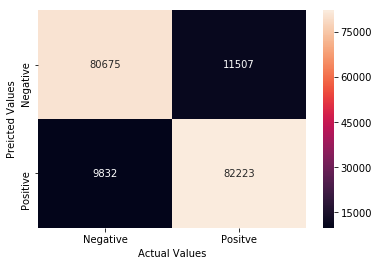

In [63]:
# generating heatmap

import seaborn as sns

df = pd.DataFrame(cm, index=["Negative", "Positive"], columns=["Negative","Positve"])
sns.heatmap(df, annot=True, fmt='d')

plt.xlabel("Actual Values")
plt.ylabel("Preicted Values")
plt.show()

In [64]:
# Generating Classification report
from sklearn.metrics import classification_report

print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     92182
           1       0.88      0.89      0.89     92055

   micro avg       0.88      0.88      0.88    184237
   macro avg       0.88      0.88      0.88    184237
weighted avg       0.88      0.88      0.88    184237



Observations:

    1) Recall  -   Recall tells us the percent of True Positive/True Negative points predicted out of total
                   Positive/Negative points. Our model predicted 89% Negative Points while 88% of Positives 
                   points correctly, which is Quite high.
    
    2) Precision - Recall tells us that out of total predicted values what percent of points were predicted correctly.
                   In Our model 88% of negative points where Truly negative out of all negative prediction.
                   Similarly 89% of positive points where Truly positive out of all positive predicted points.
                   Which is again high.
   
    Hence we can say that our model is well trained for sentiment classification.

## Lets test our model on real review 

In [65]:
# Its a real review copied from amazon of Lays product. The first one is positive rating with score 4 and second is negative rating having score 0f 2
real_review = ["It's the best flavoured chips I have ever tasted. The quality of the chips is OK. Few chips had a little black burnt part, but not much. Great for a quick snack. Mind the salt though.","Previously I ordered this many times, but this time, I received an open packet."]

In [66]:
# removing urls, html tags, alpha numeric characters, special charatcers and stopwords
processed_real_review=[]
for review in real_review:
    sentence = re.sub(r"http\S+","",review)
    sentence = BeautifulSoup(sentence, "lxml").get_text()
    sentence = contractions(sentence)
    sentence = re.sub(r"\S*\d\S*","", sentence).strip()
    sentence = re.sub(r"[^A-Za-z0-9]+"," ",sentence)
    sentence = ' '.join(sen.lower() for sen in sentence.split() if sen.lower() not in stopwords)
    processed_real_review.append(sentence.strip())

In [67]:
processed_real_review

['best flavoured chips ever tasted quality chips ok chips little black burnt part not much great quick snack mind salt though',
 'previously ordered many times time received open packet']

In [68]:
x_real_bow = vectorizer.transform(processed_real_review)

In [70]:
nb_optimal.predict_proba(x_real_bow)

array([[0.0664543 , 0.9335457 ],
       [0.84852509, 0.15147491]])

In [71]:
nb_optimal.predict(x_real_bow)

array([1, 0], dtype=int64)

# Tf-Idf

In [314]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Splitting data into train and test dataset

X = balanced_reviews["Text"].values
Y = balanced_reviews['Score'].values

x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(X,Y ,test_size=0.3, random_state=0)

print('Shape before vectorization')
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Featurization -> Text to tf-idf

tf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10)

# transforming words into tf-idf
X_train_tf = tf_vectorizer.fit_transform(x_train_tf)
X_test_tf = tf_vectorizer.transform(x_test_tf)

print('Shape after vectorization')
print(X_train_tf.shape, X_test_tf.shape)

Shape before vectorization
(429885,) (429885,)
(184237,) (184237,)
Shape after vectorization
(429885, 281220) (184237, 281220)





  0%|                                                                                           | 0/58 [00:00<?, ?it/s]


  2%|█▍                                                                                 | 1/58 [00:17<16:59, 17.89s/it]


  3%|██▊                                                                                | 2/58 [00:35<16:40, 17.87s/it]


  5%|████▎                                                                              | 3/58 [00:53<16:18, 17.80s/it]


  7%|█████▋                                                                             | 4/58 [01:11<16:05, 17.88s/it]


  9%|███████▏                                                                           | 5/58 [01:29<15:47, 17.88s/it]


 10%|████████▌                                                                          | 6/58 [01:46<15:23, 17.76s/it]


 12%|██████████                                                                         | 7/58 [02:04<15:01, 17.68s/it]


 14%|███████████▍    


MSE SCores [0.06906034044771903, 0.07190295714538608, 0.0739244239733331, 0.07552485399744646, 0.07683915977108957, 0.07791153626614533, 0.07878619117069441, 0.07975854397164905, 0.08058434365110045, 0.08141712359149156, 0.08214289903573935, 0.08287797832007426, 0.08348279237170553, 0.08405969192697371, 0.08466450435526851, 0.08517161737204282, 0.0857112971839733, 0.08609512062955282, 0.08649057506568547, 0.08689300732776561, 0.08720006581366968, 0.08759319499322393, 0.08786070902033638, 0.0881607902214101, 0.0884748285353838, 0.08880049686590041, 0.08915640511168055, 0.08940065640014283, 0.08966119157319574, 0.08991241960539609, 0.09011945250331599, 0.09040790271384169, 0.0906498272847408, 0.09080800907001696, 0.09102667257970953, 0.09120811575085264, 0.09141049689107206, 0.09154774373748586, 0.09168033752754101, 0.09187108654087817, 0.09205253019901893, 0.09224560479359778, 0.09240843828246947, 0.09261081774524027, 0.09277830450692248, 0.09295974897672876, 0.09305047164452596, 0.093

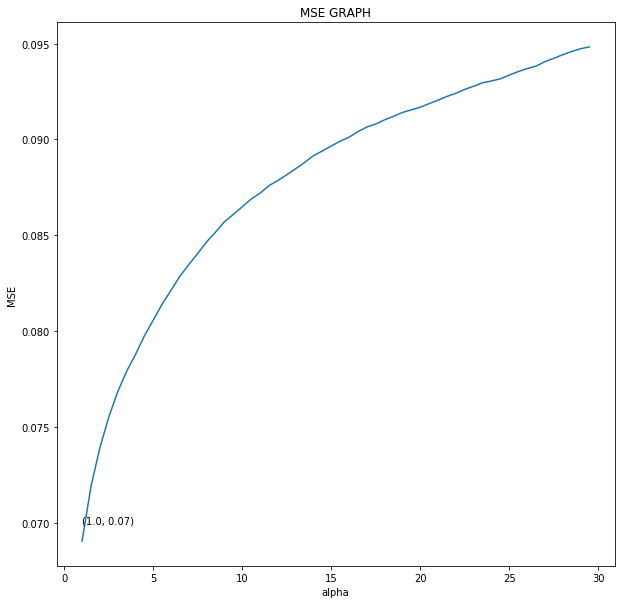

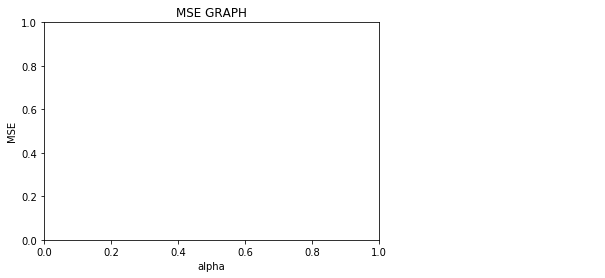

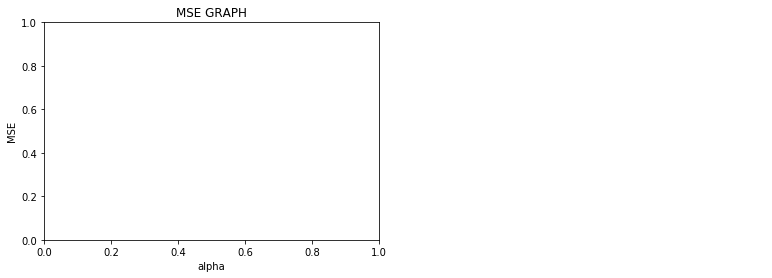

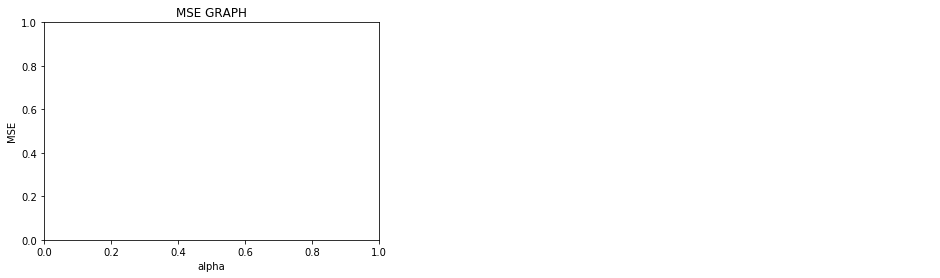

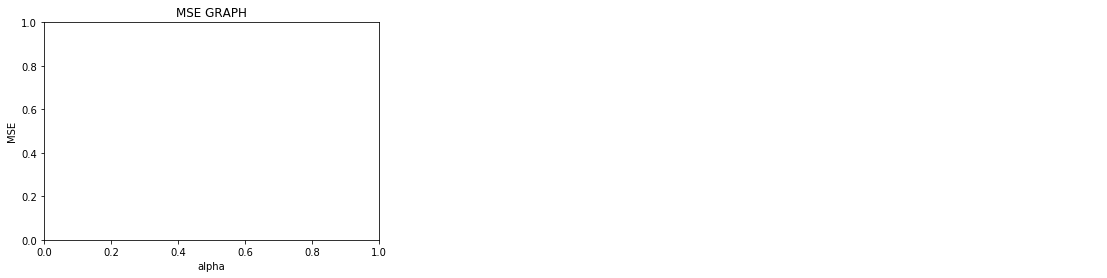

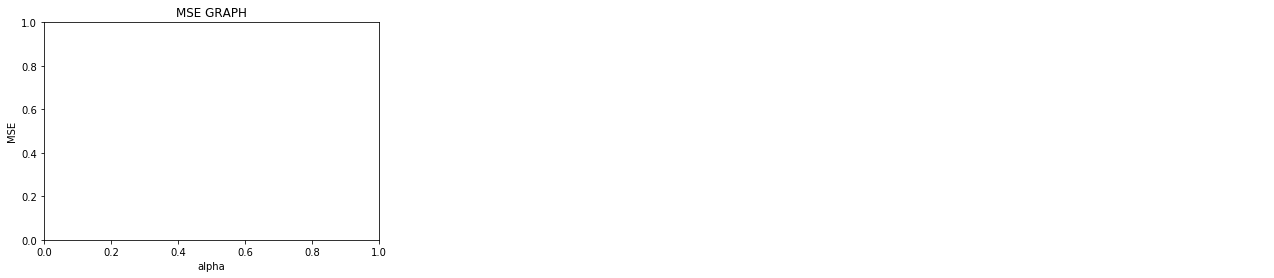

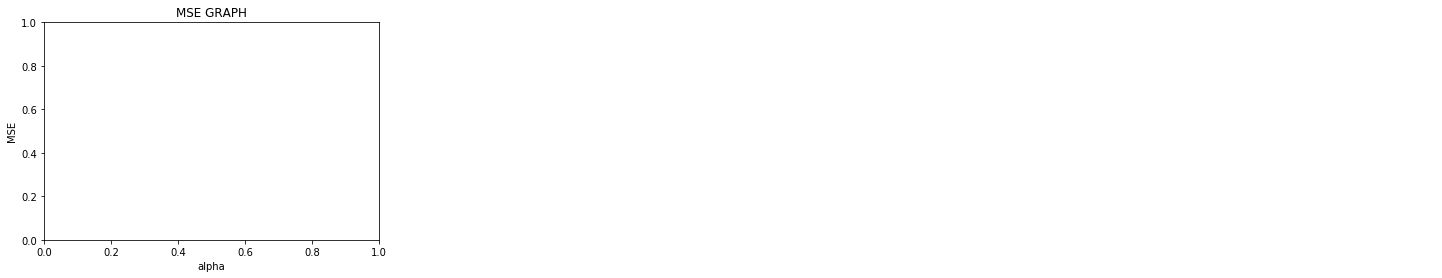

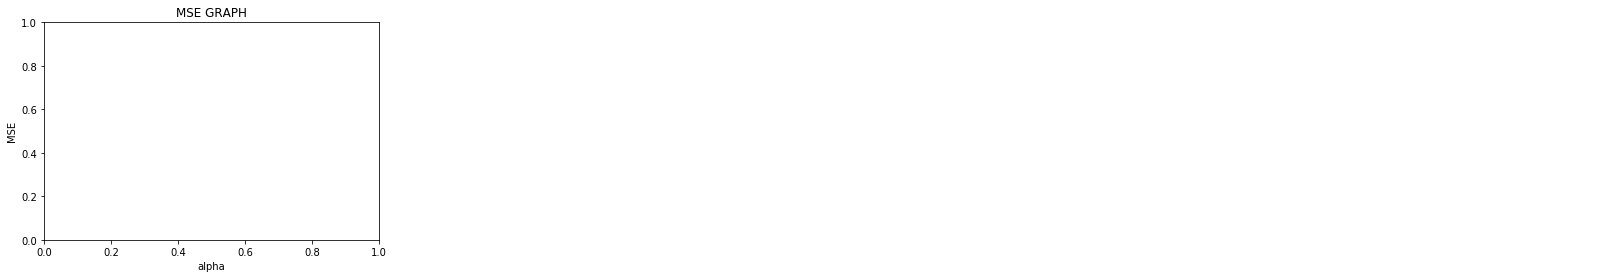

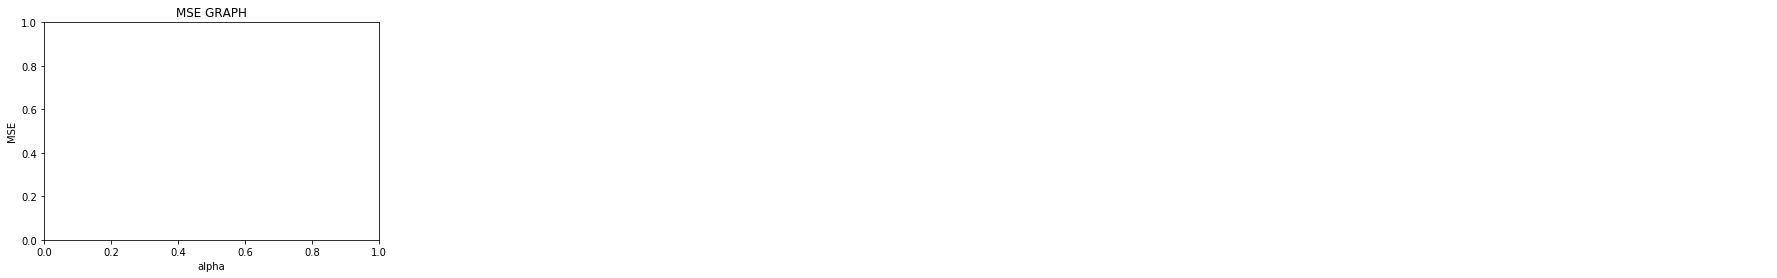

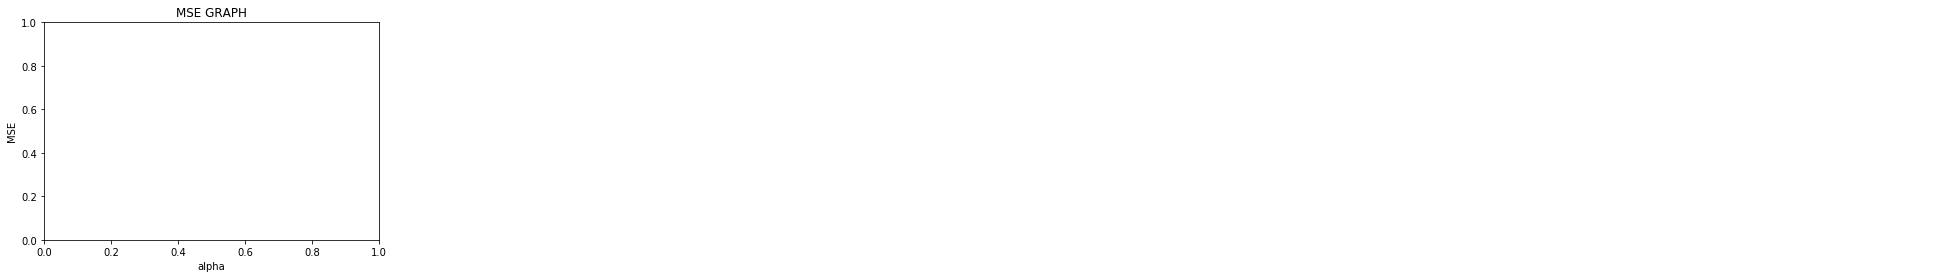

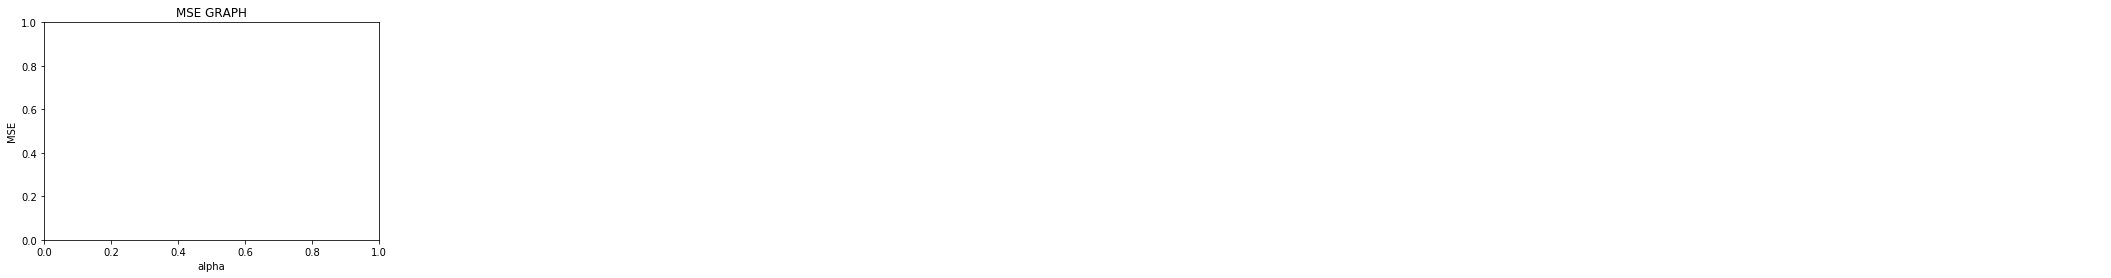

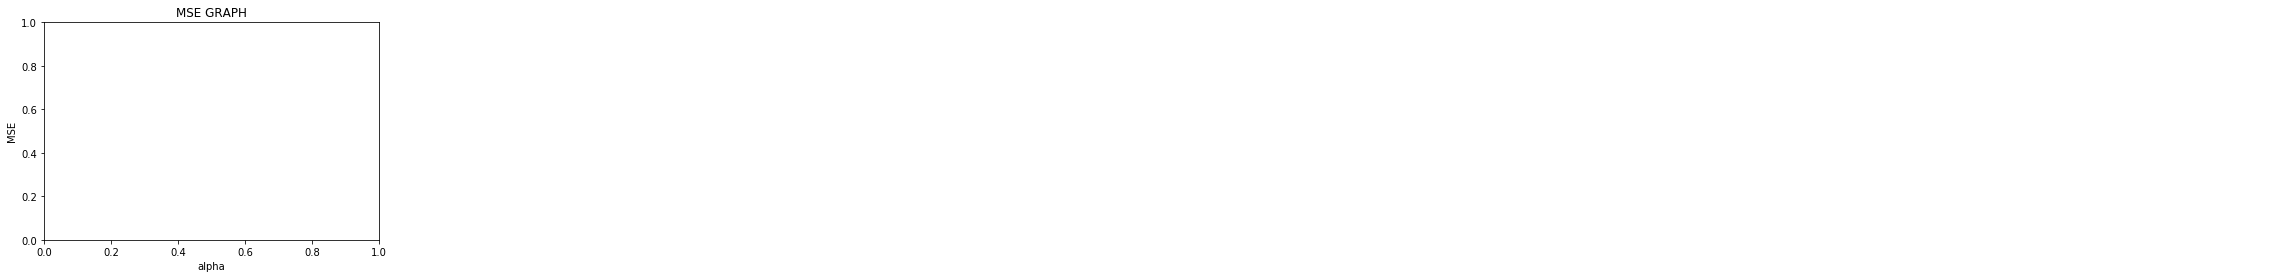

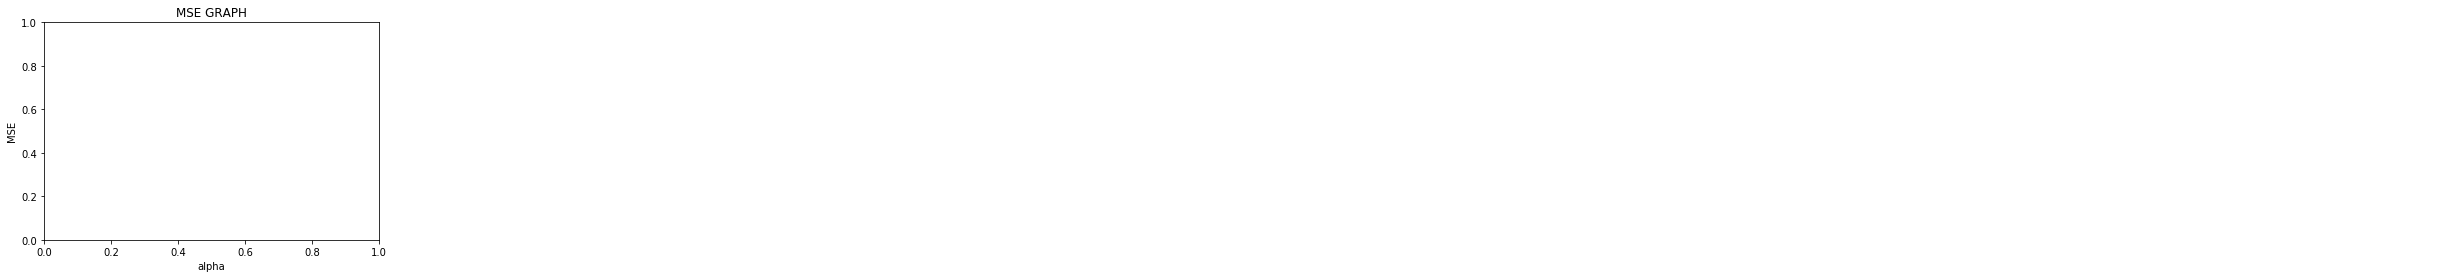

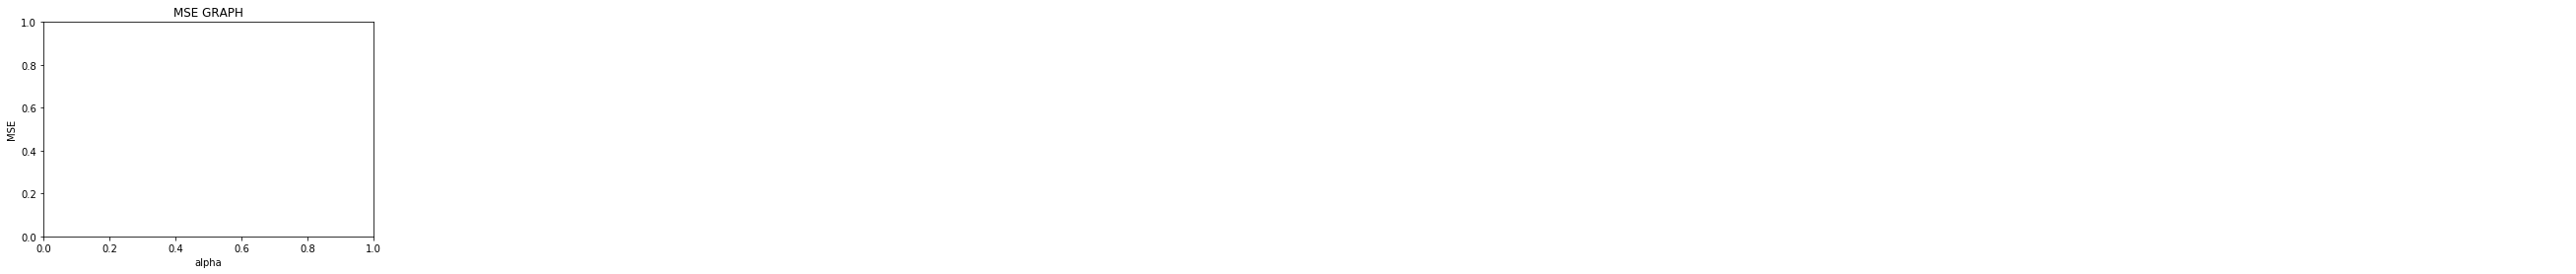

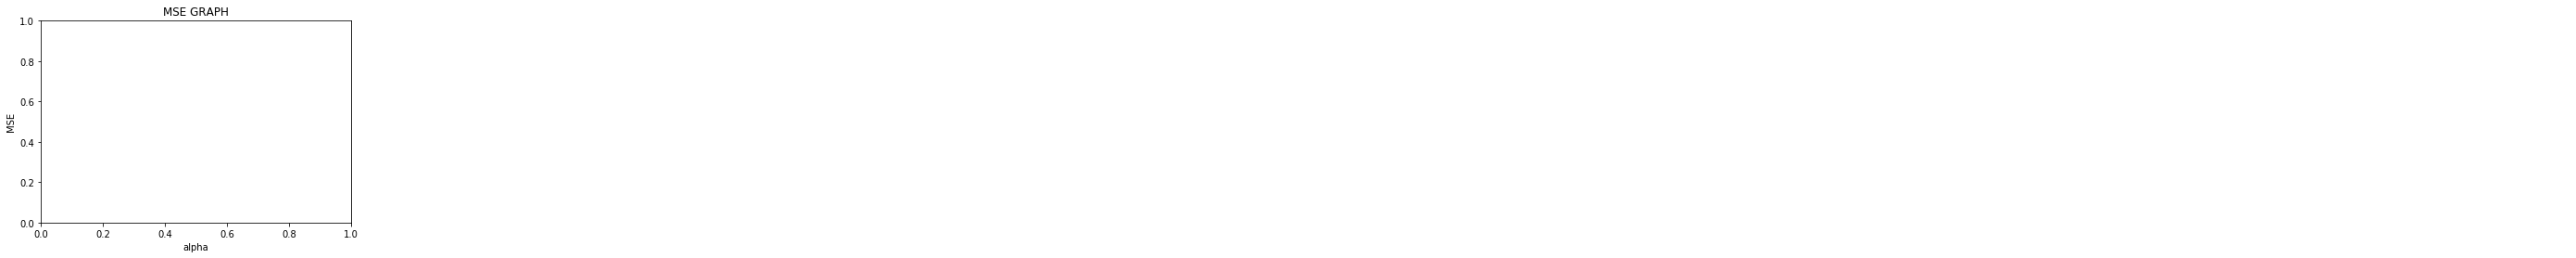

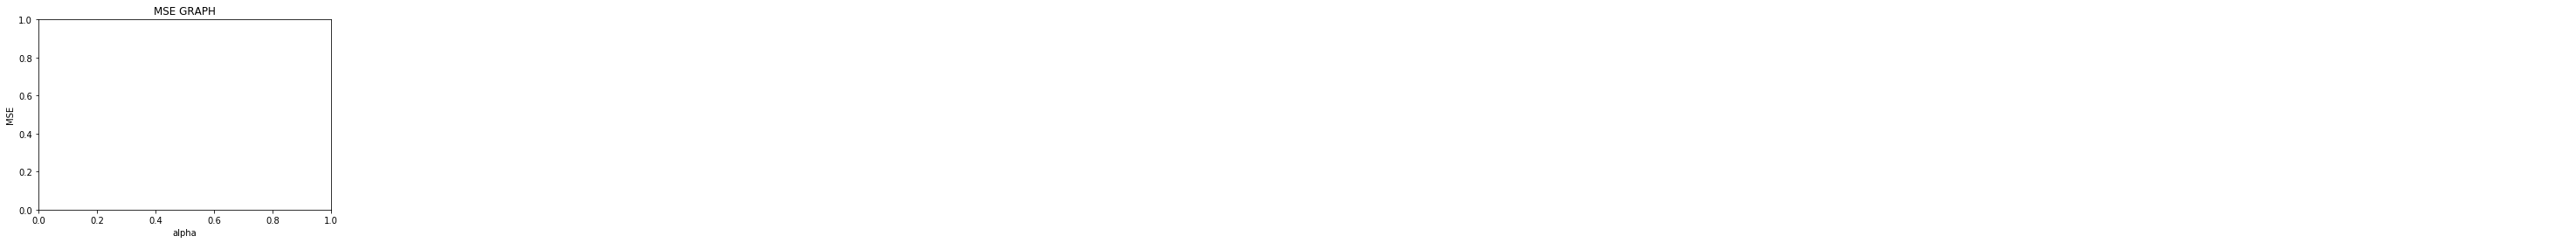

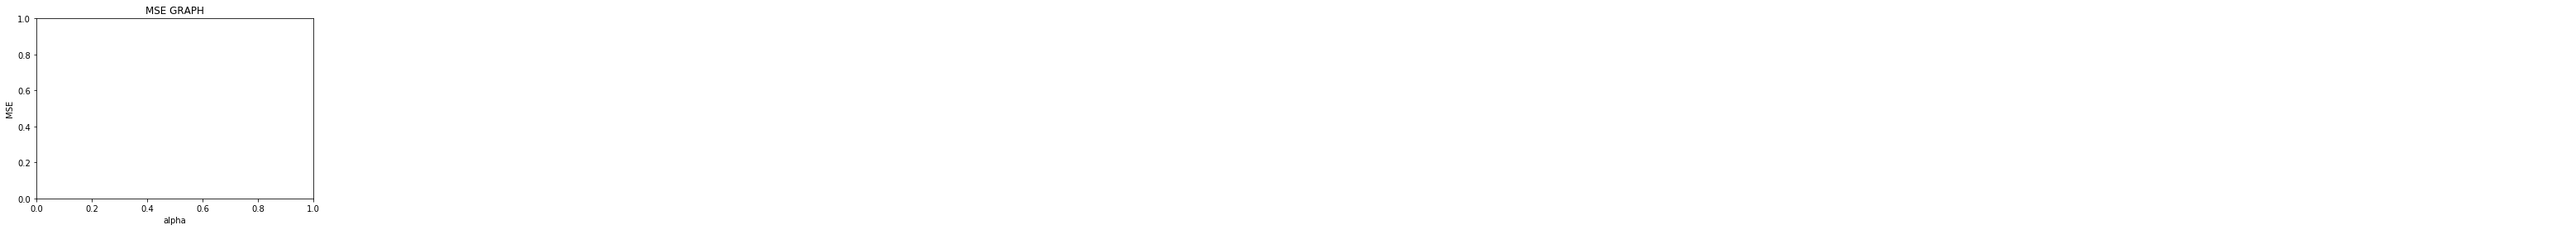

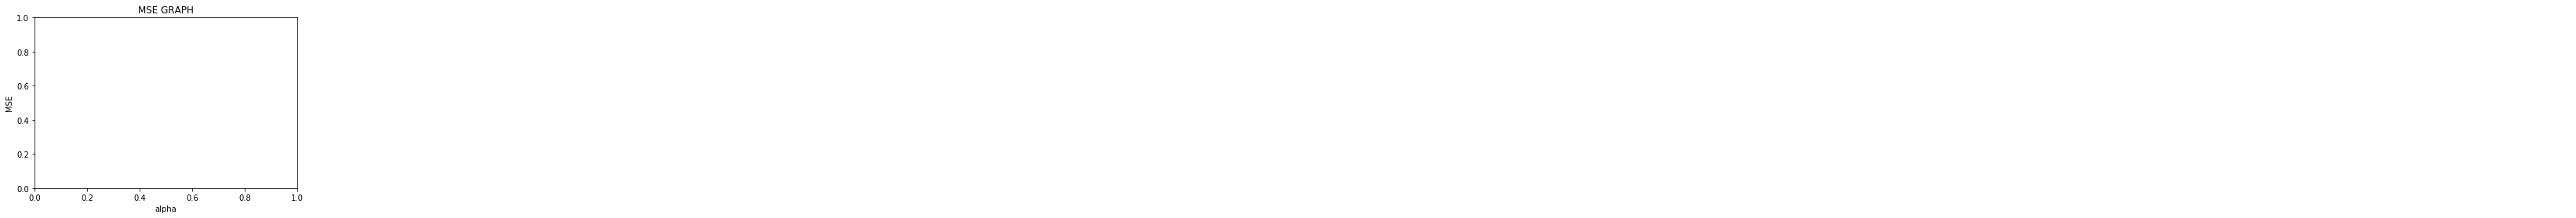

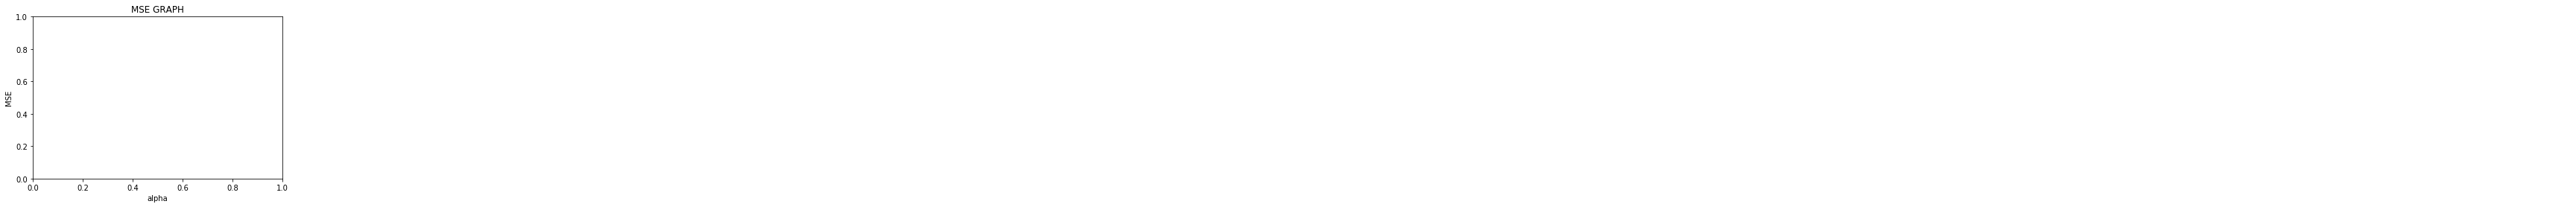

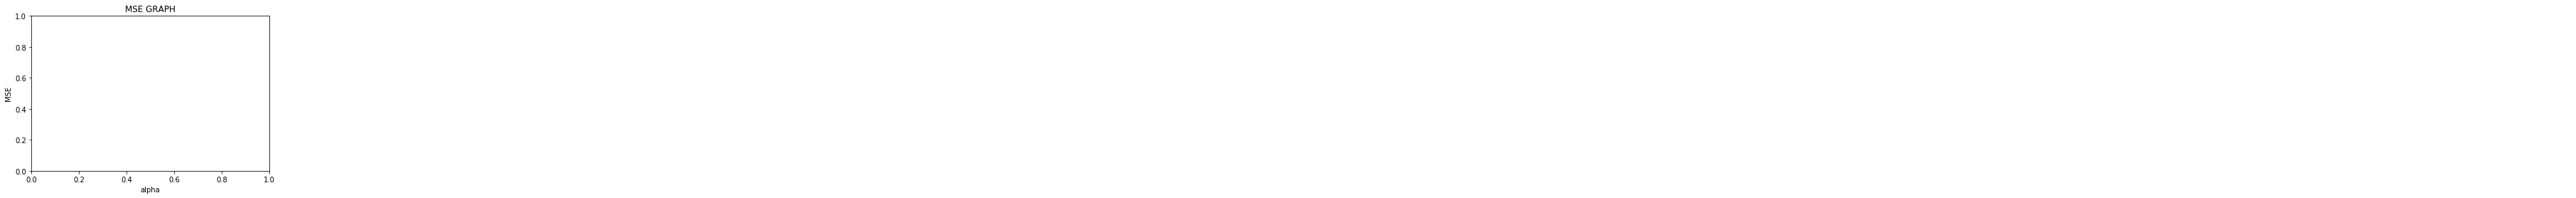

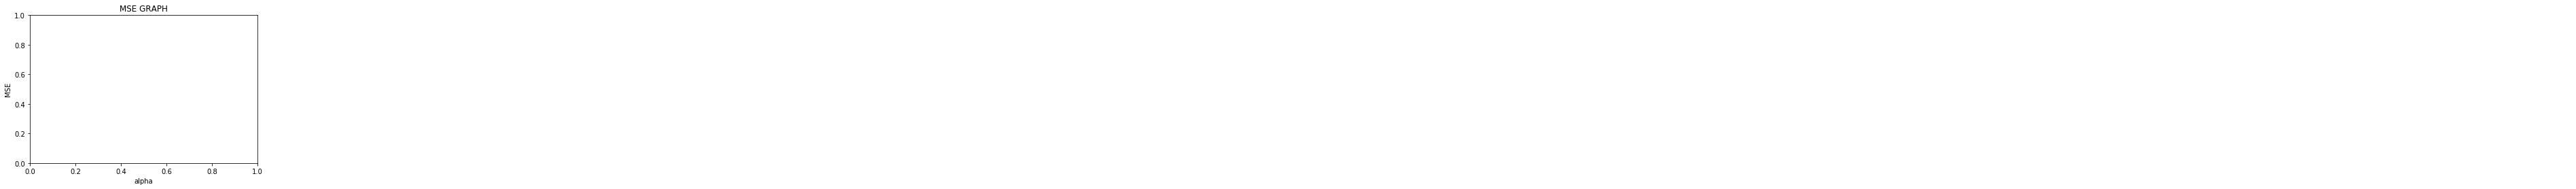

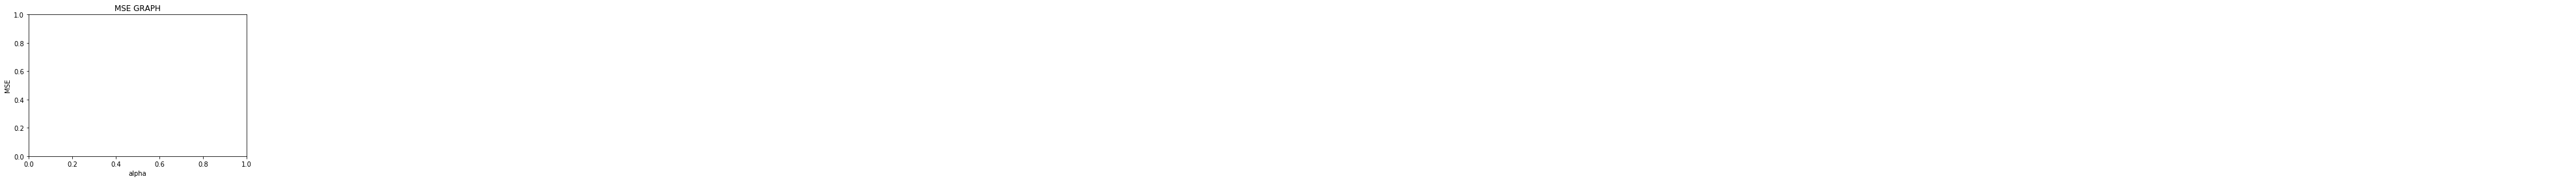

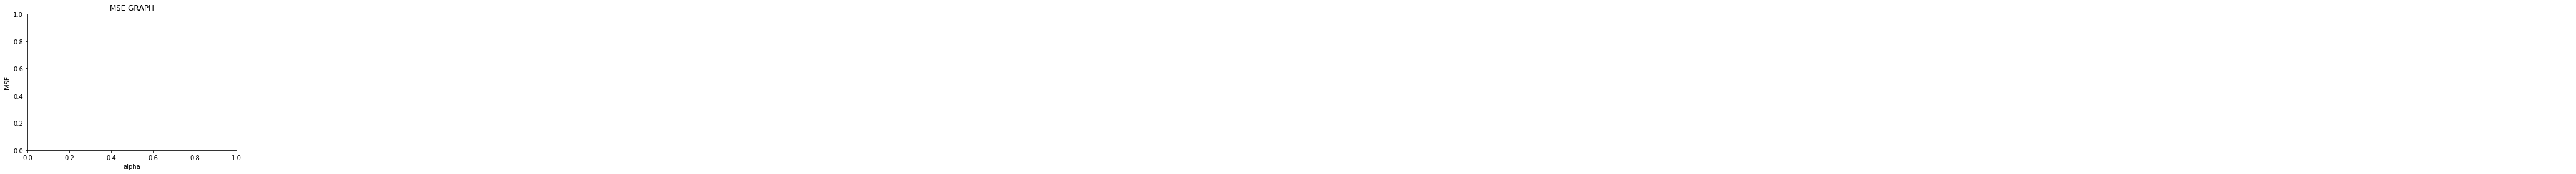

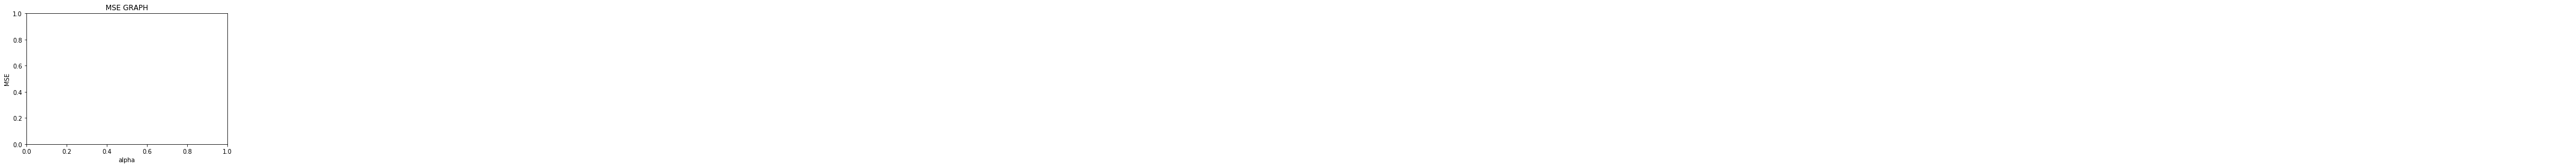

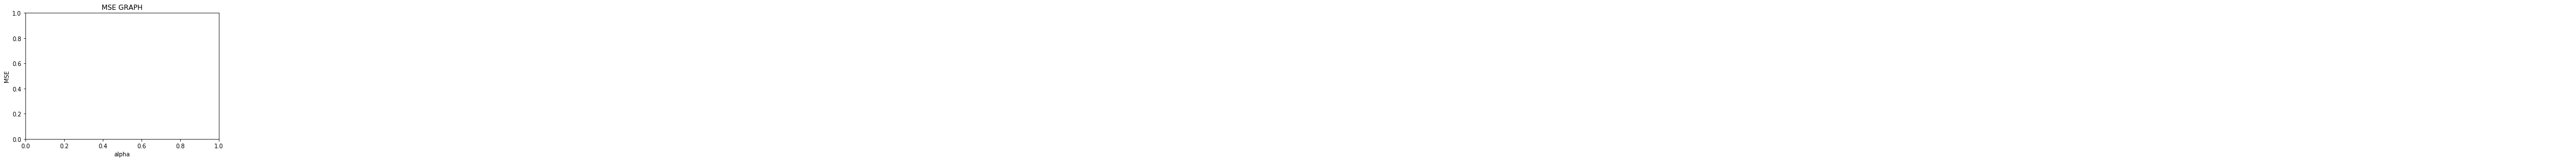

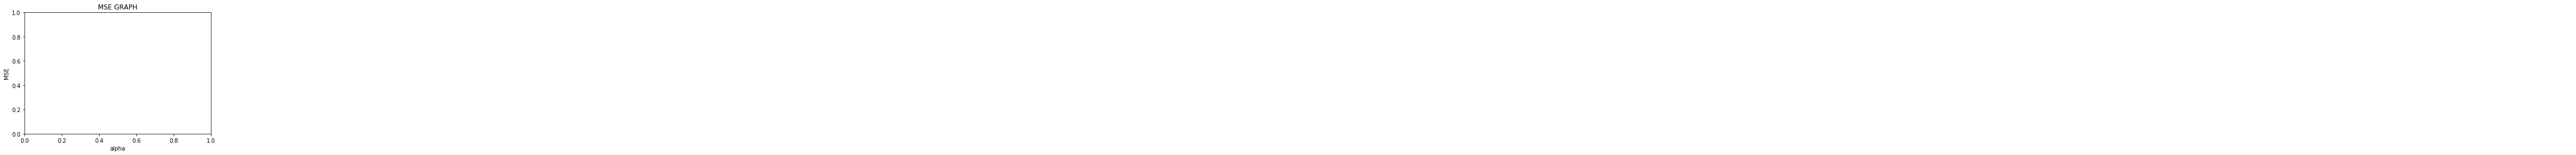

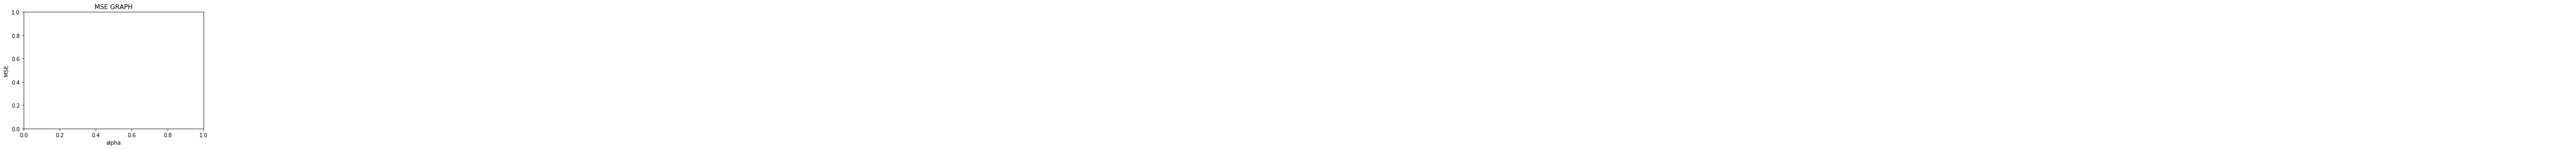

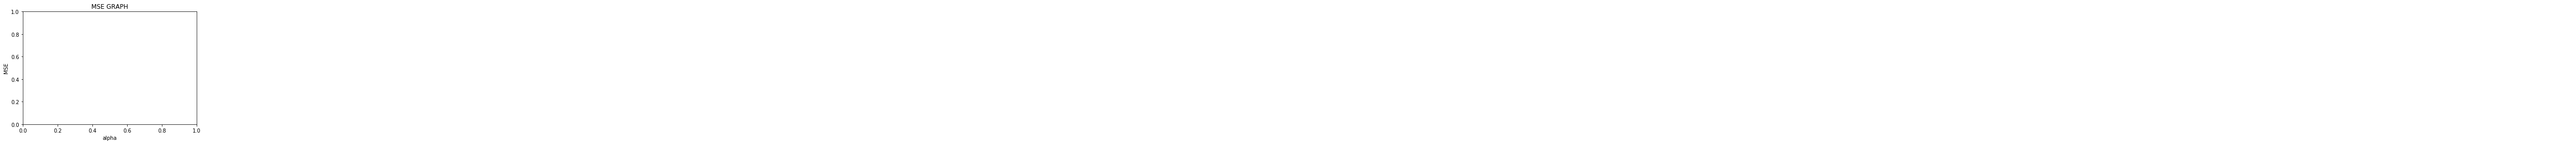

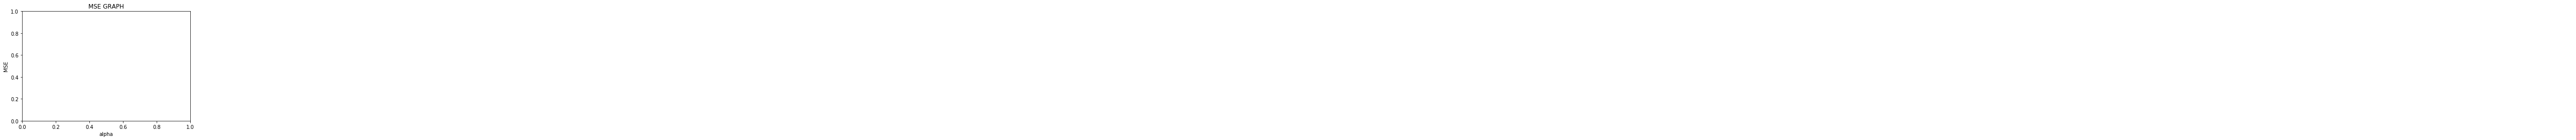

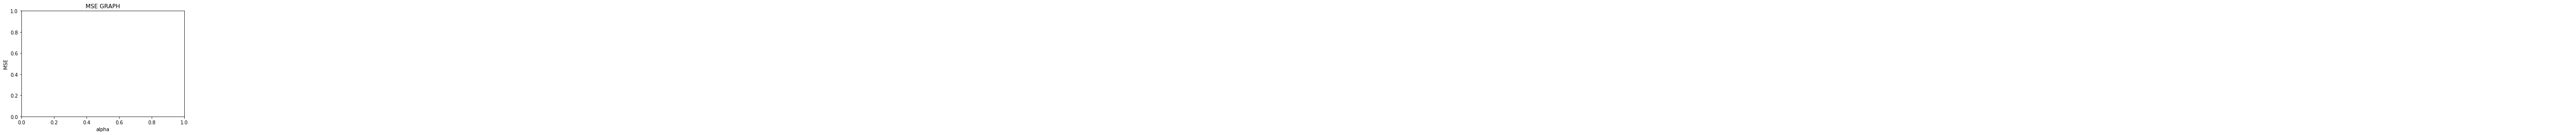

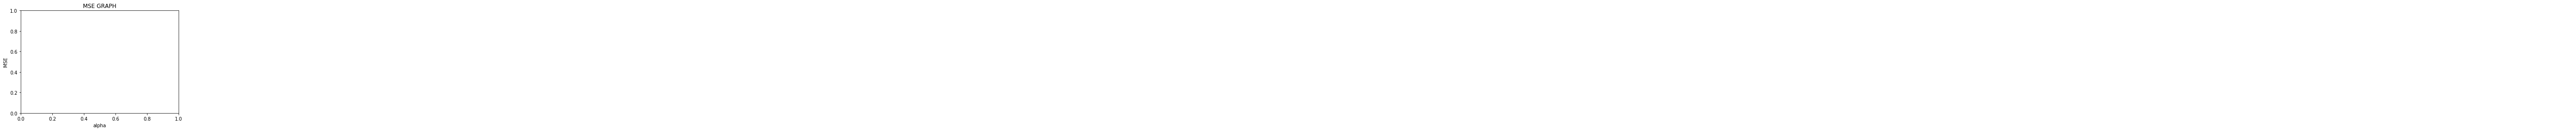

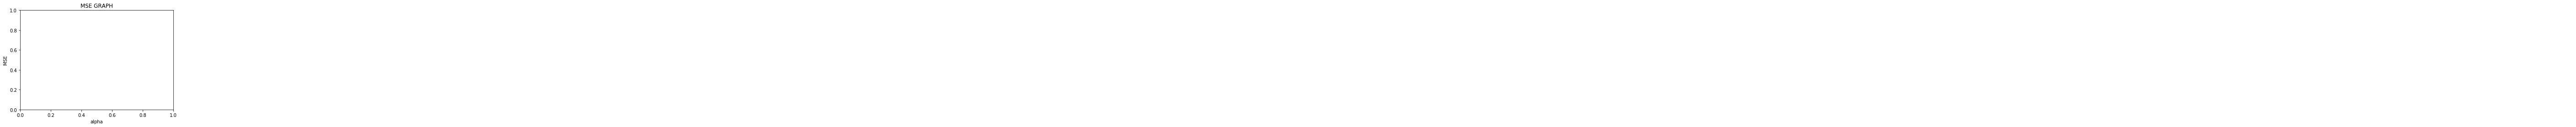

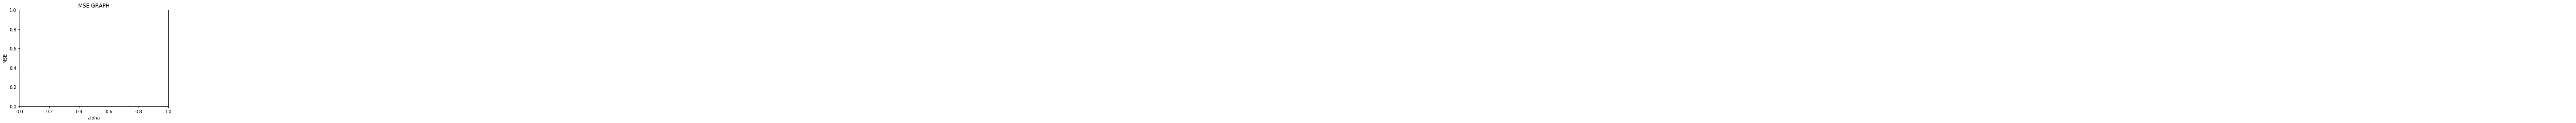

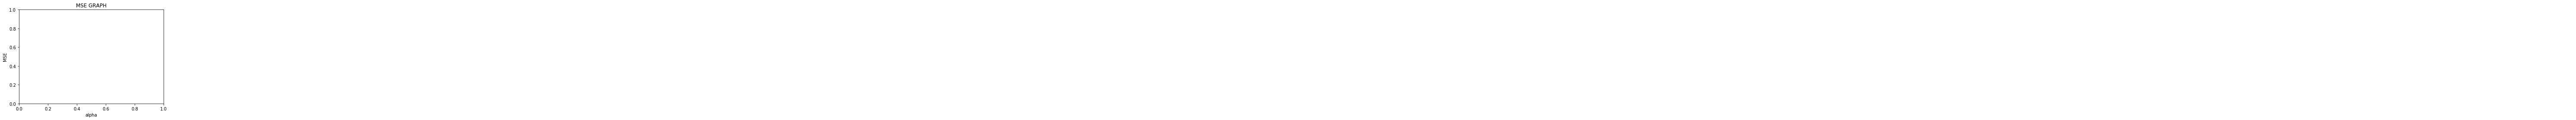

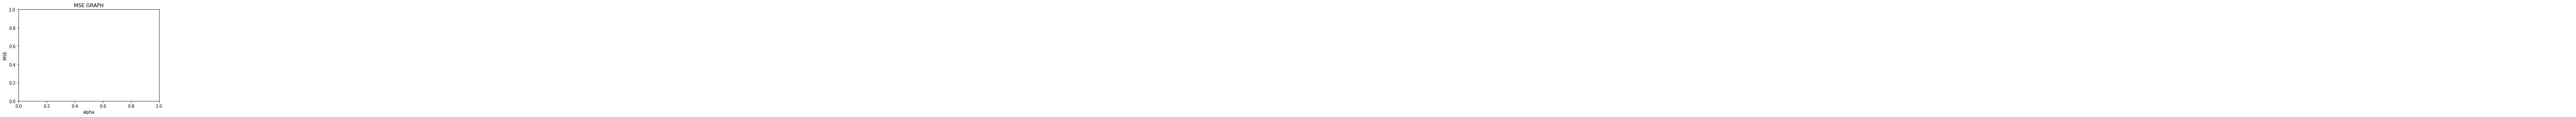

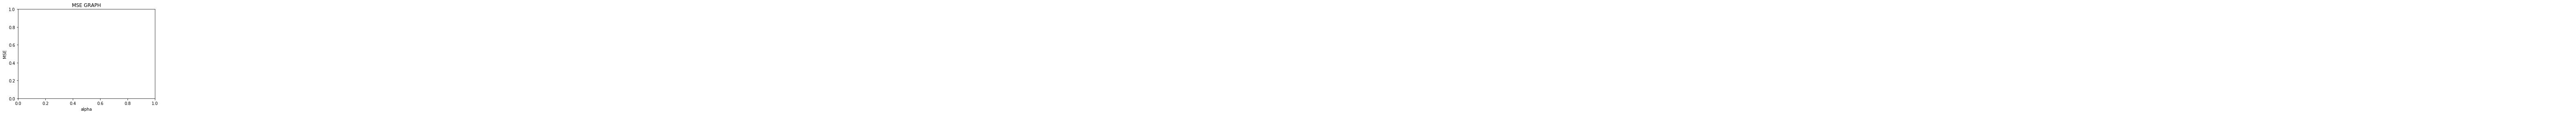

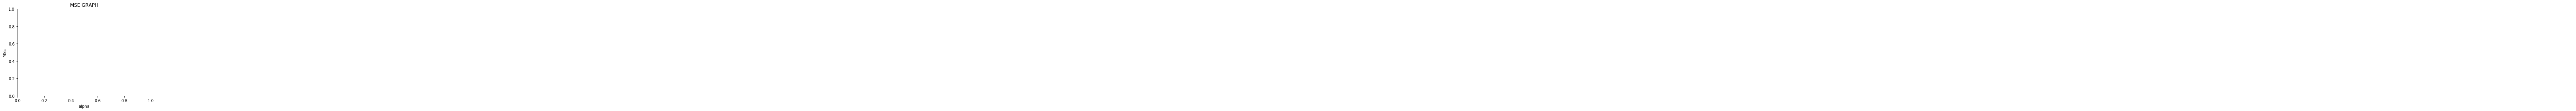

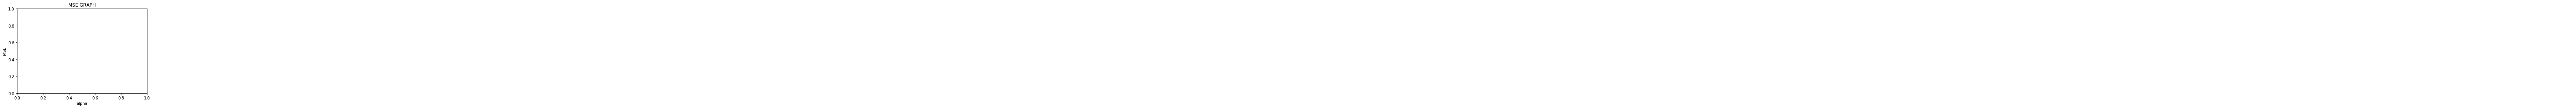

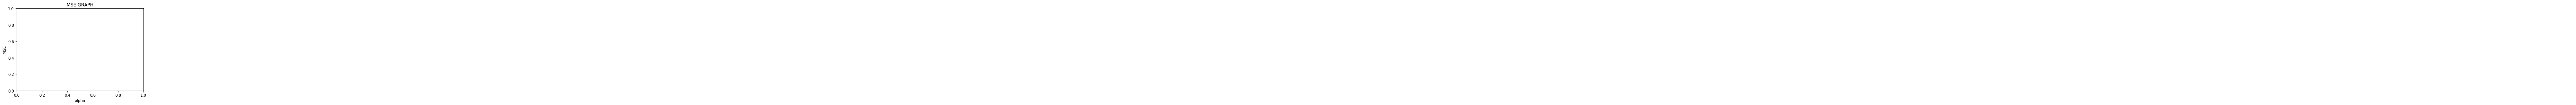

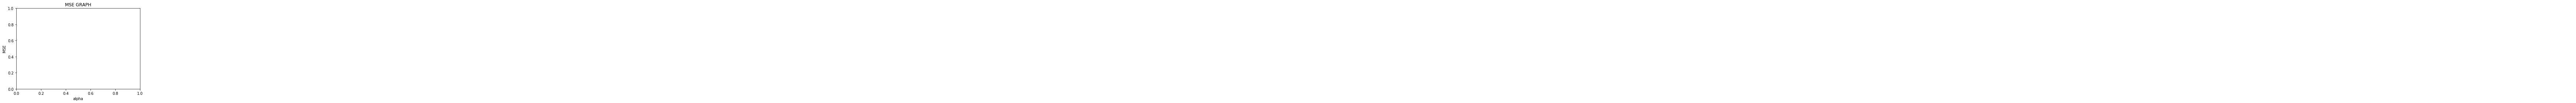

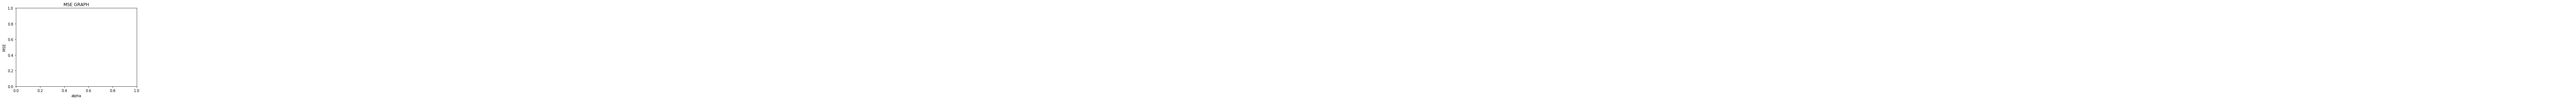

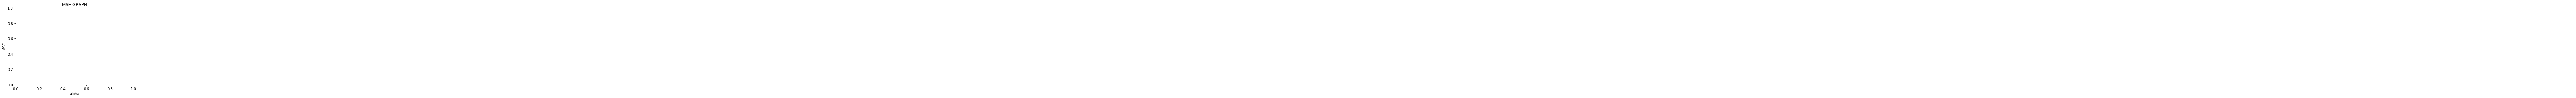

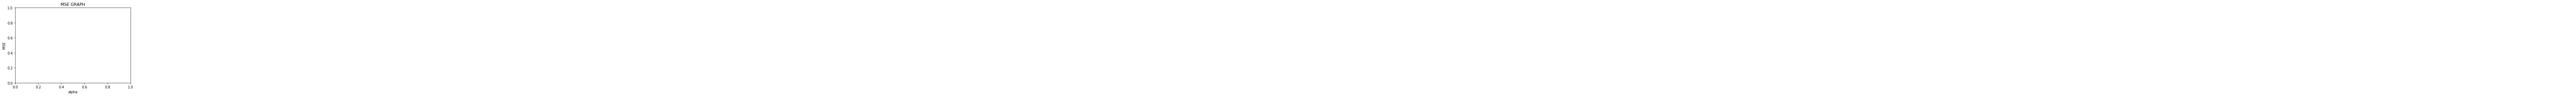

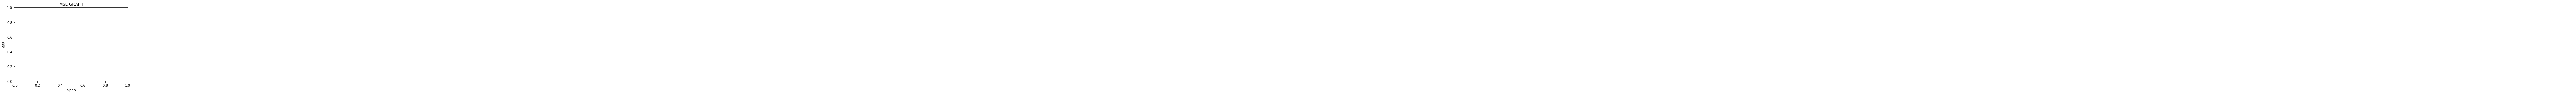

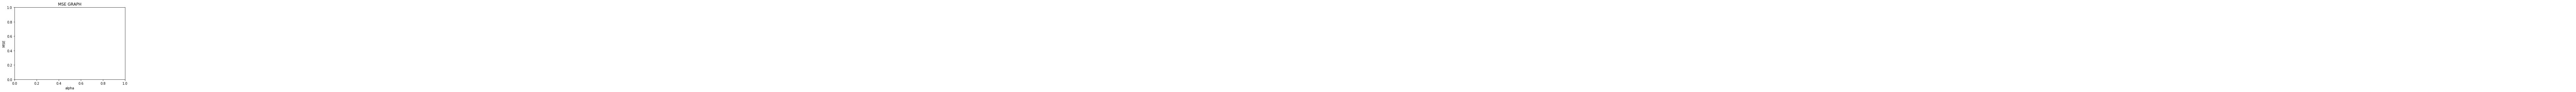

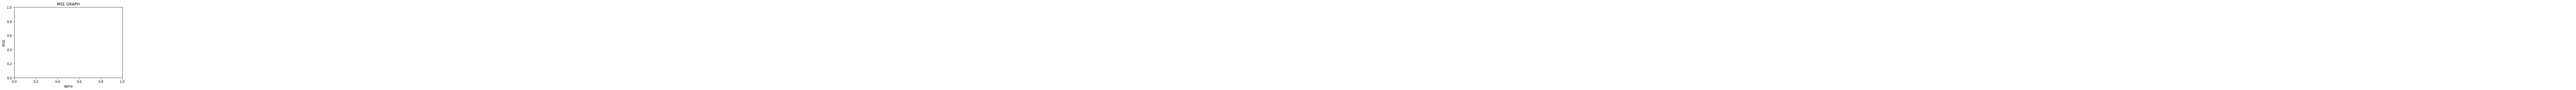

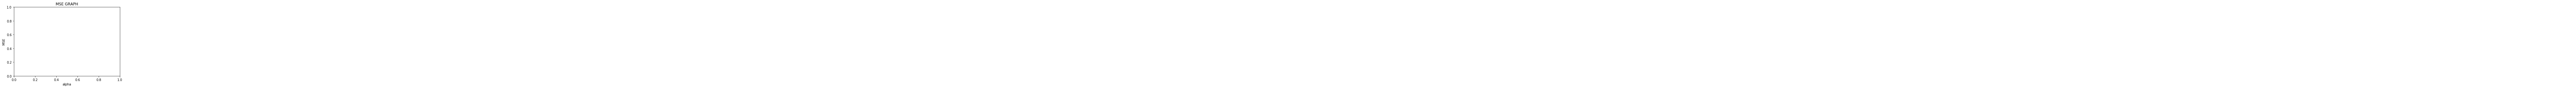

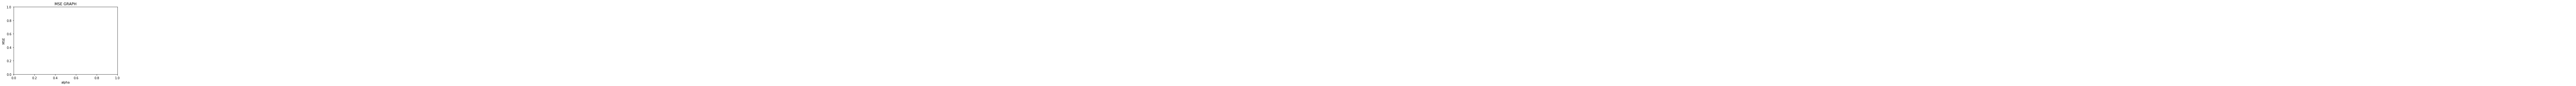

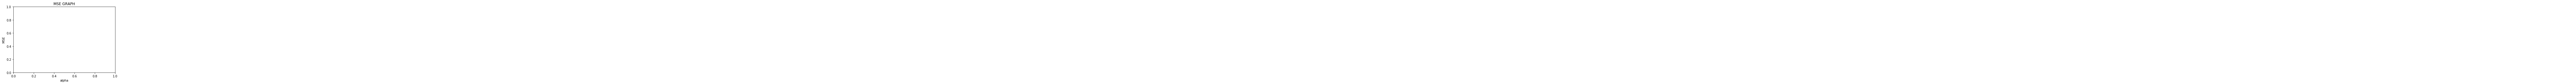

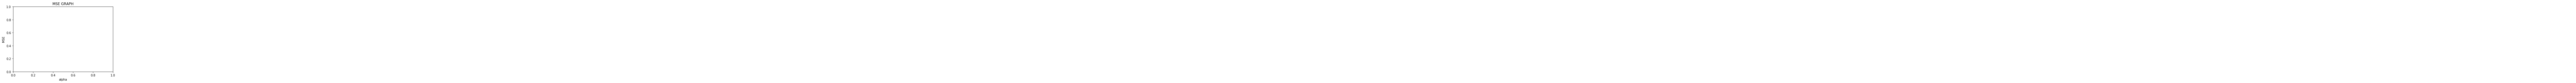

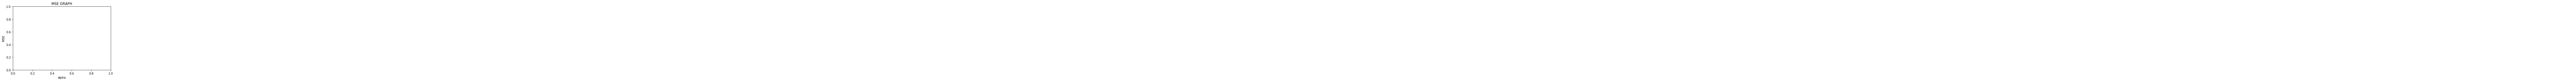

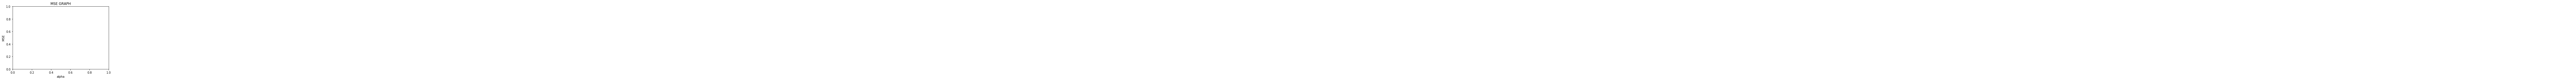

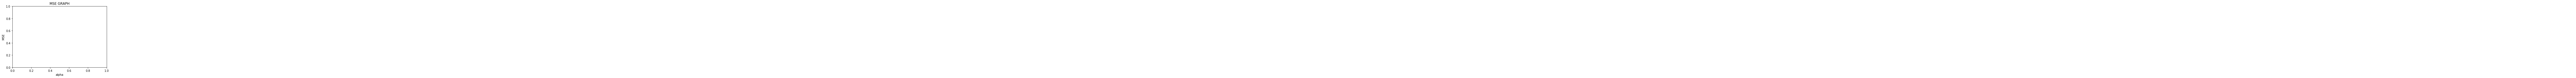

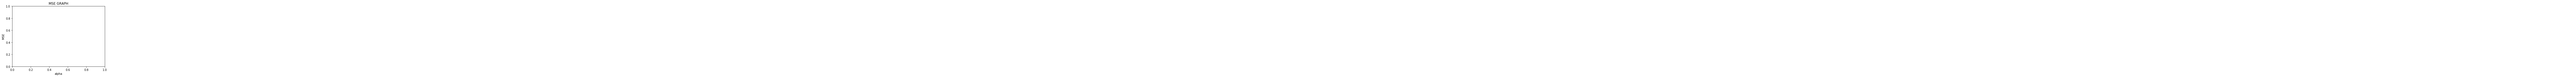

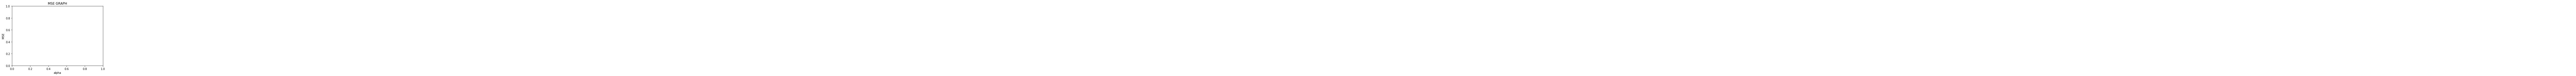

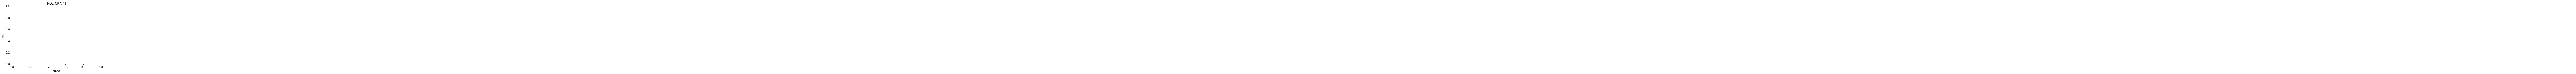

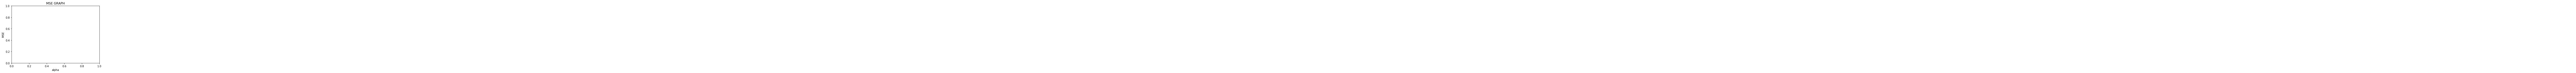

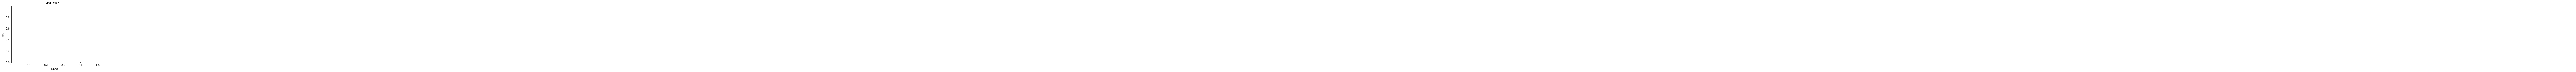

1.0

In [318]:
# finding optimal alpha using function alpha()
optimal_alpha_tf = alpha(X_train_tf, y_train_tf)
optimal_alpha_tf

## Naivebayes using Tf-idf  

In [320]:
# Initiating Naive bayes 
nb_tf = MultinomialNB(alpha=optimal_alpha_tf, class_prior=None, fit_prior=True)

# Letting the model learn
nb_tf.fit(X_train_tf, y_train_tf)

#Predicting values on X_test

pred = nb_tf.predict(X_test_tf)

# Predicting Accuracy on test data
pred_test = nb_tf.score(X_test_tf,y_test_tf)

#Predicting Accuracy on train data
pred_train = nb_tf.score(X_train_tf,y_train_tf)

print("Test Acuracy: ", pred_test*100)
print("Train Acuracy: ", pred_train*100)


Test Acuracy:  93.04754202467474
Train Acuracy:  94.44200193074892


Observation:

The accuracy on train data and accuracy of test data is almost same.


Hence we can conclude that the bias and variance tradeoff is well balanced

In [321]:
# Generating Confusion Matrix
cm_tf = confusion_matrix(y_test,pred)
cm_tf

array([[85114,  7084],
       [ 5725, 86314]], dtype=int64)

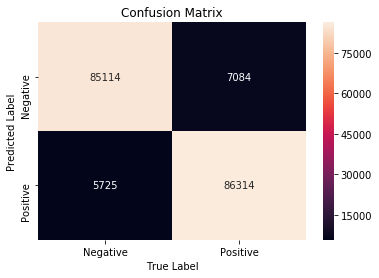

In [322]:
# generating HeatMap

df_tf = pd.DataFrame(cm_tf, index=["Negative", "Positive"], columns=["Negative","Positive"])
sns.heatmap(df_tf, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show()

In [323]:
# Generating Classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     92198
           1       0.92      0.94      0.93     92039

   micro avg       0.93      0.93      0.93    184237
   macro avg       0.93      0.93      0.93    184237
weighted avg       0.93      0.93      0.93    184237



Conclusions:

Observations:

    1) Precision - Precision tells us the percent of True Positive/True Negative points predicted out of total
                   Positive/Negative points. Our model predicted 94% Negative Points while 92% of Positives 
                   points correctly, which is Quite high.
    
    2) Recall    - Recall tells us that out of total predicted values what percent of points were predicted correctly.
                   In Our model 92% of negative points where Truly negative out of all negative prediction.
                   Similarly 94% of positive points where Truly positive out of all positive predicted points.
                   Which is again high.
   
    Hence we can say that our model is well trained for sentiment classification.